#  Review of Replication of CDS Return

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import re
import sys
from pathlib import Path

project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

from settings import config

DATA_DIR = config("DATA_DIR")



In [ ]:
from calc_cds_returns import *
from pull_fed_yield_curve import *
from pull_markit_cds import *

# reset START-DATE -- Currently, it is 1985
START_DATE = pull_markit_cds.START_DATE
END_DATE = pull_markit_cds.END_DATE

In [3]:
# Change default pandas display options
pd.options.display.max_columns = 25
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Change default figure size
plt.rcParams['figure.figsize'] = 6, 5

## 1. Introduction
This notebook replicates quarterly CDS portfolio returns as constructed in He, Kelly, and Manela (2017). However, *He et al.* do not compute CDS returns directly — instead, they use data shared by Diogo Palhares, based on his 2013 paper *"Cash-Flow Maturity and Risk Premia in CDS Markets"*, where the methodology for return construction is fully described.

> "For CDS, we construct 20 portfolios sorted by spreads using individual name 5-year contracts... Our definition of CDS returns follows Palhares (2013)."

```{note}
from Fed reserve only? there is another data source?
```

### Quarterly CDS Return
The CDS return series consists of **20 portfolios**, formed by sorting **5-year single-name CDS contracts** into quintiles based on credit spreads. Each quarter, returns are computed for portfolios within each quintile, producing 20 total portfolios.

In [ ]:
# TODO: make a function to do all the following steps 
he_kelly = pd.read_csv("../../../manual_data/He_Kelly_Manela_Factors_And_Test_Assets.csv")

In [5]:
col_lst = ["yyyyq"]
for i in range(1,10):
    col_lst.append(f"CDS_0{i}")
for i in range(10,21):
    col_lst.append(f"CDS_{i}")

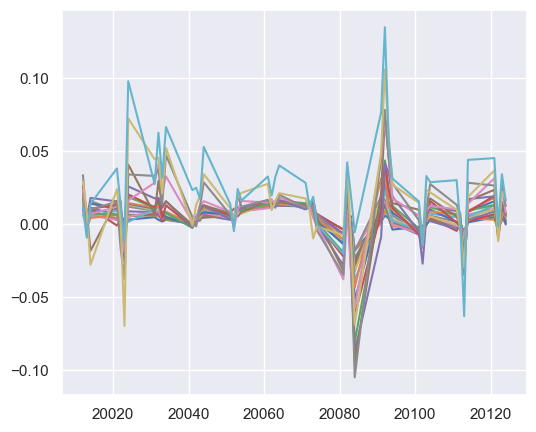

In [6]:
he_kelly_df = he_kelly[col_lst].dropna(axis=0).set_index("yyyyq")

plt.plot(he_kelly_df)
    

## 2. Data Retrival

### Step 1: Retrive data from Markit (`pull_markit_cds.py`)

To replicate the quarterly CDS return series following the methodology of Palhares (2013), we must account for both the mark-to-market value of the CDS and the coupon payments received over the quarter, along with any losses due to default. Therefore, when retrieving data from Markit, we include only the fields necessary to construct these components.

We specifically extract:

- `date`: to timestamp each observation and organize data quarterly.
- `ticker` and `RedCode`: identifiers for the reference entity, allowing entity tracking over time.
- `parspread`: the **quoted CDS spread**, used to compute premium (coupon) payments.
- `convspreard`: the conversion spread, which can be used to validate spread consistency.
- `tenor`: used to filter contracts by maturity — specifically, we later restrict to **5-year CDSs**.
- `country` and `currency`: we retain only **USD-denominated contracts** for consistency with He, Kelly, and Manela.
- `creditdv01` and `riskypv01`: key for valuing the premium leg of the CDS contract.
- `irdv01`: the interest rate DV01, indicating sensitivity to changes in the risk-free curve.
- `rec01`: sensitivity to changes in the assumed recovery rate.
- `dp`: the implied default probability, which informs risk assessment and pricing.
- `jtd`: jump-to-default — the loss from an immediate credit event.
- `dtz`: jump-to-zero — the loss assuming zero recovery in a default scenario.
- We also include only quotes where `docclause` is `"XR"` and `CompositeDepth5Y` ≥ 3 to ensure high-quality, consistent CDS quotes.

```{note}
Do we need the `country` field? Since we're filtering for USD-denominated CDS, using the `currency` field alone may be sufficient.

However, if we plan to do a disaggregated dataset, it might be useful to retain `country` and other identifiers at this stage.
```

In [7]:
# import pull_markit_cds
cds_df = pd.read_parquet("../../_data/wrds_markit/markit_cds.parquet")
# TODO: here the load_cds_data reads from _data/markit_cds.parquet instead of wrds_markit/markit_cds.parquet, so I am loading directly right now
# cds_df = pull_markit_cds.load_cds_data()

In [8]:
cds_df.columns

Index(['date', 'ticker', 'redcode', 'parspread', 'convspreard', 'tenor',
       'country', 'creditdv01', 'riskypv01', 'irdv01', 'rec01', 'dp', 'jtd',
       'dtz', 'year'],
      dtype='object')

### Step 2: Retrive data from Federal Reserve (`pull_fed_yield_curve.py`)
In this step, we download and process the [U.S. Treasury zero-coupon yield curve data]((https://www.federalreserve.gov/econres/feds/the-us-treasury-yield-curve-1961-to-the-present.htm)) published by the Federal Reserve Board. This dataset is based on the Gürkaynak, Sack, and Wright (2007) methodology, which fits a smooth yield curve to observed Treasury yields.  Zero-coupon yields for maturities from 1 year to 30 years, labeled as `SVENY01, SVENY02, ..., SVENY30`


In [9]:
import pull_fed_yield_curve

In [10]:
fed_df = pull_fed_yield_curve.load_fed_yield_curve()

In [11]:
fed_df.columns

Index(['SVENY01', 'SVENY02', 'SVENY03', 'SVENY04', 'SVENY05', 'SVENY06',
       'SVENY07', 'SVENY08', 'SVENY09', 'SVENY10', 'SVENY11', 'SVENY12',
       'SVENY13', 'SVENY14', 'SVENY15', 'SVENY16', 'SVENY17', 'SVENY18',
       'SVENY19', 'SVENY20', 'SVENY21', 'SVENY22', 'SVENY23', 'SVENY24',
       'SVENY25', 'SVENY26', 'SVENY27', 'SVENY28', 'SVENY29', 'SVENY30'],
      dtype='object')

### Step 3: Retrieve Swap rates data
We also download daily U.S. Treasury yields for the 3-month (DGS3MO) and 6-month (DGS6MO) tenors from the Federal Reserve Economic Data (FRED).

These short-term interest rates serve as risk-free rate proxies and are used in the construction of discount curves or in approximating the short end of the yield curve when computing CDS returns and risky durations.

In [12]:
# TODO: Move Swap rates func to a new pull file 
# Kausthub did not use this function, but I think at least worth trying bc He's paper mentioned this data source

In [ ]:
import calc_cds_returns

In [ ]:
swap_rates_df = calc_cds_returns.pull_swap_rates()

In [15]:
swap_rates_df.head(5)

,DGS3MO,DGS6MO
Date,,
1981-09-01,0.170,0.172
1981-09-02,0.166,0.173
1981-09-03,0.170,0.174
1981-09-04,0.166,0.174
1981-09-08,0.165,0.174


Then, we just take raw interest rate data (zero-coupon yield curves + short-term Treasury rates), clean it, align it by date, and format everything into a single, consistent DataFrame

In [16]:
def process_rates(raw_rates = None, start_date = START_DATE, end_date = END_DATE):
    """
    Processes raw interest rate data by filtering within a specified date range
    and converting column names to numerical maturity values.

    Parameters:
    - raw_rates (DataFrame): Raw interest rate data with column names like 'SVENY01', 'SVENY02', etc.
    - start_date (str or datetime): Start date for filtering.
    - end_date (str or datetime): End date for filtering.

    Returns:
    - DataFrame: Processed interest rate data with maturity values as column names and rates in decimal form.
    """
    raw_rates = raw_rates.copy().dropna()
    short_tenor_rates = pull_swap_rates(pd.to_datetime(start_date))
    short_tenor_rates_renamed = short_tenor_rates.rename(columns={
    'DGS3MO': 0.25,
    'DGS6MO': 0.5
})
    raw_rates.columns = raw_rates.columns.str.extract(r"(\d+)$")[0].astype(int)  # Extract numeric part from column names
    rates = raw_rates[
        (raw_rates.index >= pd.to_datetime(start_date)) &
        (raw_rates.index <= pd.to_datetime(end_date))
    ] # / 100  # Convert percentages to decimal format

    merged_rates = pd.merge(rates, short_tenor_rates_renamed, left_index=True, right_index=True, how='inner').sort_values('Date')
    cols = merged_rates.columns.tolist()
    ordered_cols = [0.25, 0.5] + [col for col in cols if col not in [0.25, 0.5]]
    merged_rates = merged_rates[ordered_cols]
    return merged_rates


# TODO: put it into another file
# TODO: make the urls updated -- the end date is set to March 2025 here
def pull_swap_rates(start_year = START_DATE):
    urls = {
        "DGS6MO": "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=803&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=DGS6MO&scale=left&cosd=1981-09-01&coed=2025-03-12&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-03-14&revision_date=2025-03-14&nd=1981-09-01",
        "DGS3MO": "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=803&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=DGS3MO&scale=left&cosd=1981-09-01&coed=2025-03-12&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-03-14&revision_date=2025-03-14&nd=1981-09-01"
    }

    dataframes = {}
    for key, url in urls.items():
        response = requests.get(url)
        response.raise_for_status()  
        
        df = pd.read_csv(io.StringIO(response.text), parse_dates=["observation_date"])
        df.columns = ["observation_date", key]  
        dataframes[key] = df

    # Merge dataframes on DATE
    df_merged = dataframes["DGS3MO"].merge(dataframes["DGS6MO"], on="observation_date", how="outer")
    df_merged = df_merged.rename(columns = {"observation_date": "Date"})
    df_merged = df_merged.set_index("Date")
    df_merged = df_merged[start_year:]
    df_merged = df_merged.dropna(axis=0)
    df_merged = df_merged / 100
    return df_merged

In [17]:
rates_df = process_rates(fed_df,start_date = START_DATE, end_date = END_DATE)

In [19]:
rates_df.head(5)

,0.250,0.500,1.000,2.000,3.000,4.000,5.000,6.000,7.000,8.000,9.000,10.000,...,19.000,20.000,21.000,22.000,23.000,24.000,25.000,26.000,27.000,28.000,29.000,30.000
Date,,,,,,,,,,,,,,,,,,,,,,,,,
1985-11-25,0.074,0.077,7.855,8.363,8.747,9.041,9.269,9.448,9.592,9.711,9.811,9.897,...,10.402,10.443,10.482,10.520,10.555,10.589,10.622,10.653,10.682,10.710,10.736,10.762
1985-11-26,0.074,0.077,7.853,8.357,8.742,9.038,9.268,9.449,9.596,9.715,9.816,9.902,...,10.378,10.415,10.450,10.483,10.514,10.543,10.572,10.598,10.623,10.647,10.670,10.692
1985-11-27,0.074,0.076,7.843,8.352,8.734,9.023,9.245,9.419,9.559,9.673,9.769,9.851,...,10.338,10.378,10.416,10.451,10.485,10.518,10.548,10.577,10.605,10.631,10.656,10.680
1985-11-29,0.074,0.076,7.791,8.315,8.699,8.985,9.202,9.371,9.506,9.617,9.711,9.794,...,10.299,10.340,10.380,10.417,10.453,10.486,10.518,10.548,10.576,10.603,10.629,10.653
1985-12-02,0.075,0.077,7.818,8.346,8.736,9.029,9.255,9.433,9.577,9.696,9.798,9.887,...,10.409,10.448,10.486,10.521,10.553,10.584,10.613,10.640,10.666,10.690,10.712,10.733


In [25]:
rates_df.to_csv("rates_df.csv")

## 3. Replication
To replicate the quarterly CDS return, we follow the formulas below as suggested in *He-Kelly-Manela (2017)*, page 45, referencing Palhares:

$$
\text{CDSRet}_t = \frac{\text{CDS}_{t-1}}{250} + \Delta \text{CDS}_t \cdot \text{RD}_{t-1}
$$

where:
- $\frac{\text{CDS}_{t-1}}{250}$: **Carry return** — daily accrual of the previous day’s spread (annualized and spread over 250 days),
- $\Delta \text{CDS}_t = \text{CDS}_t - \text{CDS}_{t-1}$: daily change in CDS spread,
- $\text{RD}_{t-1}$: **risky duration** at time $t-1$, approximating the present value of future spread payments.

    $$
    \text{RD}_t = \frac{1}{4} \sum_{j=1}^{4M} e^{-j\lambda/4} \cdot e^{-jr_t^{(j/4)}/4}
    $$

    where:
    - $M$: maturity in years (e.g., 5),
    - $\lambda$: default intensity, estimated as:
    $$
    \lambda = 4 \cdot \log \left(1 + \frac{\text{CDS}}{4L} \right)
    $$
    with $L$ = loss given default, typically 60% (i.e., $L = 0.6$).

    - $r_t^{(j/4)}$: risk-free rate for quarter $j/4$ at time $t$,
    - The discounting is done using the term structure of interest rates (e.g., Treasury + swaps as per Gurkaynak et al.).

### Step 4. `get_portfolio_dict`
**Here I wrote my own understanding to the function, if there is anything wrong, plz advice.**

In [ ]:
import calc_cds_returns

def get_portfolio_dict(start_date = START_DATE, end_date = END_DATE, cds_spreads = None):
    """
    Creates a dictionary of credit portfolios based on the CDS spread data.

    Parameters:
    - start_date (str or datetime): Start date for filtering.
    - end_date (str or datetime): End date for filtering.
    - cds_spreads (pl.DataFrame): CDS spread data.
    
    Returns:
    - dict: Dictionary where keys are tenor-quantile pairs and values are Polars DataFrames.
    """

    if isinstance(start_date, str):
        start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    if isinstance(end_date, str):
        end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    if isinstance(cds_spreads, pd.DataFrame):
        cds_spreads = pl.from_pandas(cds_spreads)
    # Filter DataFrame
    filtered_cds_spread = cds_spreads.filter(
        (pl.col("date") >= start_date) & (pl.col("date") <= end_date)
    )
    filtered_cds_spread_us_only = filtered_cds_spread.filter(pl.col("country") == "United States")
    # Data Cleaning and Preparation
    cds_spread_noNA = filtered_cds_spread_us_only.drop_nulls(subset=["parspread"])
    cds_spread_noNA = cds_spread_noNA.drop(['convspreard', 'year', 'redcode'])

    # Remove duplicates
    cds_spread_unique = cds_spread_noNA.unique()
    
    # TODO: here filter by parspread value was not mentioned in paper?
    cds_spread_unique = cds_spread_unique.filter(pl.col("parspread") <= 0.5)

    # Convert date column to year-month format
    cds_spread_unique = cds_spread_unique.with_columns(
        pl.col("date").dt.strftime("%Y-%m").alias("year_month")
    )

    # Compute Credit Quantiles
    spread_5y = cds_spread_unique.filter(pl.col("tenor") == "5Y")

    # Get first available spread for each ticker in each month
    first_spread_5y = (
        spread_5y.sort("date")
        .group_by(["ticker", "year_month"])
        .first()
        .select(["ticker", "year_month", "parspread"])
    )
    # TODO: quantile?
    # Compute separate credit quantiles per month
    credit_quantiles = (
        first_spread_5y.group_by("year_month").agg([
            pl.col("parspread").quantile(0.2).alias("q1"),
            pl.col("parspread").quantile(0.4).alias("q2"),
            pl.col("parspread").quantile(0.6).alias("q3"),
            pl.col("parspread").quantile(0.8).alias("q4")
        ])
    )

    # Assign credit quantile labels
    first_spread_5y = first_spread_5y.join(credit_quantiles, on="year_month")

    first_spread_5y = first_spread_5y.with_columns(
        pl.when(pl.col("parspread") <= pl.col("q1"))
        .then(1)
        .when(pl.col("parspread") <= pl.col("q2"))
        .then(2)
        .when(pl.col("parspread") <= pl.col("q3"))
        .then(3)
        .when(pl.col("parspread") <= pl.col("q4"))
        .then(4)
        .otherwise(5)
        .alias("credit_quantile")
    ).select(["ticker", "year_month", "credit_quantile"])

    # Assign computed credit quantiles to all tenors
    cds_spreads_final = cds_spread_unique.join(
        first_spread_5y, on=["ticker", "year_month"], how="left"
    )
    cds_spreads_final = cds_spreads_final.sort("date")

    # Compute Representative Parspread
    relevant_tenors = ["3Y", "5Y", "7Y", "10Y"]
    relevant_quantiles = [1, 2, 3, 4, 5]

    filtered_df = cds_spreads_final.filter(
        (pl.col("tenor").is_in(relevant_tenors)) & 
        (pl.col("credit_quantile").is_in(relevant_quantiles))
    )

    rep_parspread_df = (
        filtered_df
        .group_by(["date", "tenor", "credit_quantile"])
        .agg(pl.col("parspread").mean().alias("rep_parspread"))
    )

    # Convert 'date' column to month level (truncate to the first day of the month)
    rep_parspread_df = rep_parspread_df.with_columns(
        pl.col("date").dt.truncate("1mo").alias("month")
    )

    portfolio_dict = {}

    for tenor in relevant_tenors:
        for quantile in relevant_quantiles:
            key = f"{tenor}_Q{quantile}"  # Example key: "5Y_Q3"
            
            # Filter dataframe for this specific tenor-quantile pair
            portfolio_df = rep_parspread_df.filter(
                (pl.col("tenor") == tenor) & (pl.col("credit_quantile") == quantile)
            )

            portfolio_df = portfolio_df.sort("date")
            
            # Store in dictionary
            portfolio_dict[key] = portfolio_df
    return portfolio_dict
portfolio_dict = get_portfolio_dict(start_date = START_DATE, end_date = END_DATE, cds_spreads = cds_df)

### **Step 5: Interpolating Quarterly Risk-Free Rates**

**in the paper, the term is extrapolation, but by definition, it should be interpolation???**

One term we need to compute in the CDS return formula is an exponential discount factor involving the risk-free rate, specifically of the form $e^{-\frac{j \cdot r_t^{(j/4)}}{4}}$, where $r_t^{(j/4)}$ is the rate for quarter $j/4$ at time $t$.

However, our available yield data includes only a limited set of maturities: 3-month, 6-month, and annual terms from 1Y to 30Y. To obtain the necessary rates at intermediate quarterly maturities (e.g., 0.75Y, 1.25Y, 1.5Y, etc.), we follow the approach suggested in thye paper and apply **interpolation** across the term structure. This interpolation step allows us to estimate risk-free rates for arbitrary quarterly horizons, which are essential for accurately computing discount factors and the risky duration component in the CDS return calculation.


In [20]:
def extrapolate_rates(rates = None):
    """
    Applies cubic spline extrapolation to fill in interest rate values at quarterly intervals.

    Parameters:
    - rates (DataFrame): A DataFrame where columns represent maturity years,
                         and values are interest rates.

    Returns:
    - df_quarterly: A DataFrame with interpolated rates at quarterly maturities.
    """
    years = np.array(rates.columns)
    
    # Define the new maturities at quarterly intervals (0.25, 0.5, ..., 30)
    quarterly_maturities = np.arange(0.25, 30.25, 0.25)
    # 3m, 6m, 9m, 1Y, 1.25Y, 1.5Y, 1.75Y, 2Y 

    interpolated_data = []

    for _, row in rates.iterrows():
        values = row.values  # Get values for the current row
        cs = CubicSpline(years, values, extrapolate=True)  # Create spline function
        interpolated_values = cs(
            quarterly_maturities
        )  # Interpolate for quarterly intervals
        interpolated_data.append(interpolated_values)  # Append results

    # Create a new DataFrame with interpolated values for all rows
    df_quarterly = pd.DataFrame(interpolated_data, columns=quarterly_maturities)
    df_quarterly.index = rates.index
    return df_quarterly

def calc_discount(raw_rates = None, start_date = START_DATE, end_date = END_DATE):
    """
    Calculates the discount factor for given interest rate data using quarterly rates.

    Parameters:
    - raw_rates (DataFrame): The raw interest rate data.
    - start_date (str or datetime): The start date for filtering.
    - end_date (str or datetime): The end date for filtering.

    Returns:
    - DataFrame: Discount factors for various maturities.
    """
    # Call the function to get rates
    rates_data = process_rates(raw_rates, start_date, end_date)
    if rates_data is None:
        print("No data available for the given date range.")
        return None

    quarterly_rates = extrapolate_rates(rates_data)

    quarterly_discount = pd.DataFrame(
        columns=quarterly_rates.columns, index=quarterly_rates.index
    )
    for col in quarterly_rates.columns:
        quarterly_discount[col] = quarterly_rates[col].apply(
            lambda x: np.exp(-(col * x) / 4)
        )

    return quarterly_discount

In [22]:
quarterly_discount = calc_discount(fed_df, start_date = START_DATE, end_date = END_DATE)

In [23]:
quarterly_discount.head(3)

,0.250,0.500,0.750,1.000,1.250,1.500,1.750,2.000,2.250,2.500,2.750,3.000,...,27.250,27.500,27.750,28.000,28.250,28.500,28.750,29.000,29.250,29.500,29.750,30.000
Date,,,,,,,,,,,,,,,,,,,,,,,,,
1985-11-25,0.995,0.990,0.496,0.140,0.045,0.022,0.017,0.015,0.011,0.007,0.003,0.001,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1985-11-26,0.995,0.990,0.497,0.140,0.045,0.023,0.017,0.015,0.011,0.007,0.003,0.001,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1985-11-27,0.995,0.990,0.497,0.141,0.045,0.023,0.017,0.015,0.011,0.007,0.003,0.001,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000



### Step6. Calculate daily return 
`calc_cds_return_for_portfolios()` calculates lambda, risk duration, and finally the risk-free return of each quantilextenor combo.

### Step7. Aggreate the monthly return
`calculate_monthly_returns` aggregates the monthly reutrn.


## 4. Graph